In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

In [ ]:
df = pd.read_csv('/content/sample_data/VCB.csv')
df

,Date,Close,Open,High,Low,Vol.,Change %
0,12/1/2017,36620,36847,37075,36392,2.66M,-0.41%
1,12/4/2017,37454,36772,37454,36620,2.48M,2.28%
2,12/5/2017,36468,37151,37909,36468,2.52M,-2.63%
3,12/6/2017,36392,36392,36620,35710,2.68M,-0.21%
4,12/7/2017,36089,36392,36392,35407,3.49M,-0.83%
...,...,...,...,...,...,...,...
1369,6/1/2023,93900,94600,94600,93200,646.30K,-0.11%
1370,6/2/2023,94900,93900,95000,93300,737.80K,1.06%
1371,6/5/2023,98000,95200,98700,95200,1.30M,3.27%
1372,6/6/2023,99000,98000,99000,96500,759.50K,1.02%


In [ ]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập validation
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Lấy các giá trị đóng cửa của tập huấn luyện
train_close_prices = train_data['Close'].values

# Chuẩn hóa dữ liệu về phạm vi từ 0 đến 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_close_prices.reshape(-1, 1)).flatten()



In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
# Tạo exogenous variable
exog_train = np.arange(len(train_data)).reshape(-1, 1)


# Tìm hiểu các tham số tối ưu cho mô hình ARIMA
model = auto_arima(y=scaled_train_prices[:-1], exogenous=exog_train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Lấy các tham số tối ưu từ kết quả
p = model.order[0]
d = model.order[1]
q = model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3917.005, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3915.480, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3913.549, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3913.538, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3916.072, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3913.120, Time=3.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3912.569, Time=3.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3915.926, Time=4.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3913.664, Time=2.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3912.167, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3912.332, Time=2.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3911.176, Time=0.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3913.567, Time=2.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3917.610, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0

In [ ]:
# Tạo một mô hình ARIMAX với các tham số tối ưu
arimax_model = ARIMA(endog=scaled_train_prices, order=(p, d, q), exog=exog_train)

# Huấn luyện mô hình ARIMAX
arimax_model_fit = arimax_model.fit()


In [ ]:

# Dự đoán trên tập validation
val_close_prices = val_data['Close'].values
scaled_val_prices = scaler.transform(val_close_prices.reshape(-1, 1))
exog_val = np.arange(len(train_data), len(train_data) + len(val_data)).reshape(-1, 1)  # Chỉ số của dữ liệu validation
exog_val = np.reshape(exog_val, (len(exog_val), 1))  # Thay đổi hình dạng của exog_val
val_predictions = arimax_model_fit.predict(start=len(train_data), end=len(train_data) + len(val_data) - 1, exog=exog_val)




In [ ]:
# Tính toán các độ đo đánh giá trên tập validation
val_output = scaled_val_prices
val_mape = mean_absolute_percentage_error(val_output, val_predictions)
val_mse = mean_squared_error(val_output, val_predictions)
val_mae = mean_absolute_error(val_output, val_predictions)
val_rmse = np.sqrt(val_mse)

In [ ]:
# Tính toán các độ đo đánh giá trên tập test
test_close_prices = test_data['Close'].values
scaled_test_prices = scaler.transform(test_close_prices.reshape(-1, 1)).flatten()
test_predictions = arima_model_fit.predict(n_periods=len(scaled_test_prices), exogenous=scaled_test_prices)
test_output = scaled_test_prices
test_mape = mean_absolute_percentage_error(test_output, test_predictions)
test_mse = mean_squared_error(test_output, test_predictions)
test_mae = mean_absolute_error(test_output, test_predictions)
test_rmse = np.sqrt(test_mse)

In [ ]:
# In các độ đo đánh giá
print('Validation MAPE:', val_mape)
print('Validation MSE:', val_mse)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Test MAPE:', test_mape)
print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test RMSE:', test_rmse)

Validation MAPE: 0.11277397263781422
Validation MSE: 0.017310670730008186
Validation MAE: 0.1108705492628507
Validation RMSE: 0.13157002215553582
Test MAPE: 0.4383647901638439
Test MSE: 0.19142544090980573
Test MAE: 0.402061114097181
Test RMSE: 0.43752193191862476


In [ ]:
# Quá trình tạo index dự đoán cho 30 ngày tiếp theo
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Tạo một mảng 30 số nguyên liên tiếp bắt đầu từ last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=exog_next30)

# In ra giá dự đoán cho 30 ngày tiếp theo
print('Giá dự đoán cho 30 ngày tiếp theo:')
print(y_next_30_days)


Giá dự đoán cho 30 ngày tiếp theo:
[0.99183438 0.99448167 0.9971275  0.99977188 1.0024148  1.00505626
 1.00769627 1.01033482 1.01297192 1.01560756 1.01824174 1.02087447
 1.02350574 1.02613556 1.02876392 1.03139083 1.03401627 1.03664027
 1.03926281 1.04188389 1.04450351 1.04712168 1.0497384  1.05235366
 1.05496746 1.05757981 1.0601907  1.06280013 1.06540811 1.06801463]


In [ ]:
# Scale dự đoán trở lại với đơn vị gốc
predicted_prices = scaler.inverse_transform(y_next_30_days.reshape(-1, 1))


In [ ]:
# Tạo mảng ngày tương ứng với các dự đoán
last_date = pd.to_datetime(df['Date'].iloc[-1])
predicted_dates = pd.date_range(start=last_date, periods=30, closed='right')


<ipython-input-35-9df4e995ebcc>:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=last_date, periods=30, closed='right')


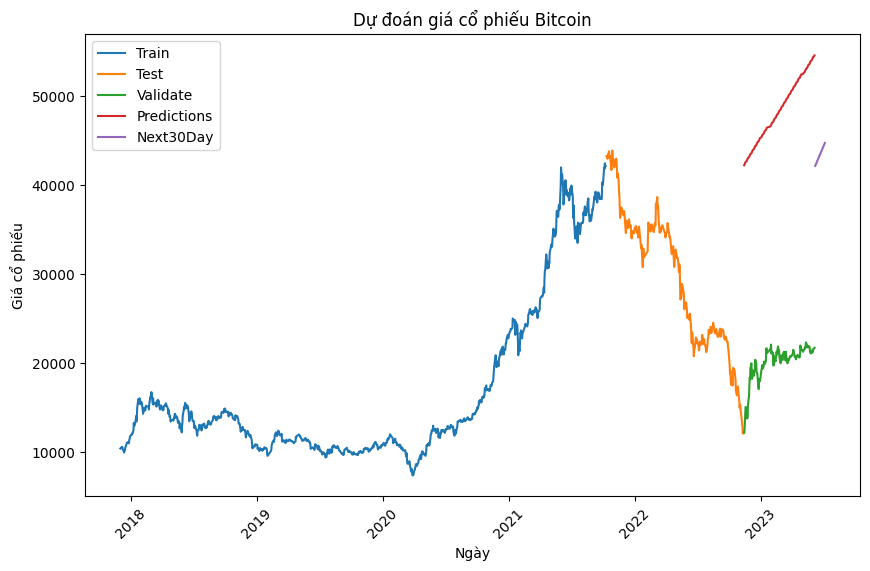

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(train_data['Date']), train_data['Close'], label='Train')
plt.plot(pd.to_datetime(test_data['Date']), test_data['Close'], label='Test')
plt.plot(pd.to_datetime(val_data['Date'][:-1]), val_close_prices[:-1], label='Validate')
plt.plot(pd.to_datetime(val_data['Date'][:-1]), scaler.inverse_transform(val_predictions[:-1].reshape(-1, 1)).flatten(), label='Predictions')
plt.plot(predicted_dates, predicted_prices[:-1], label='Next30Day')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Dự đoán giá cổ phiếu')
plt.legend()
plt.xticks(rotation=45)
plt.show()